### Importation of the libraries

In [63]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import lime
from lime import lime_image
import shap
from tensorflow.keras.applications import VGG16  # Replace with your pre-trained model if not VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2  # Import cv2 for image processing
from matplotlib import pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from skimage.transform import resize
from tensorflow.keras.models import Model
# from tf_keras_vis.gradcam import Gradcam

### data processing 

In [64]:
# Path to the data directory on your local PC
data_dir = r'C:\Users\InkoHamza\Desktop\PFE_HEALTHCARE\data'

print("no. of normal images :", len(os.listdir(data_dir + '/normal')))
print("no. of tuberculosis images :", len(os.listdir(data_dir + '/tuberculosis')))

no. of normal images : 3180
no. of tuberculosis images : 350


In [65]:
def preprocess_images(image_dir, label):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):  # Adjust this line if your images have different extensions
            image_path = os.path.join(image_dir, filename)
            image = Image.open(image_path)
            image = image.convert("RGB")  # Convert grayscale to RGB
            image = image.resize((256, 256))  # Resize images to 256x256 pixels
            image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
            images.append(image)
            labels.append(label)
    return images, labels

In [66]:
# Path to the data directory on your local PC
data_dir = r'C:\Users\InkoHamza\Desktop\PFE_HEALTHCARE\data'
normal_dir = os.path.join(data_dir, 'normal')
tuberculosis_dir = os.path.join(data_dir, 'tuberculosis')

In [67]:
# Load and preprocess normal images
normal_images, normal_labels = preprocess_images(normal_dir, label=0)
# Load and preprocess tuberculosis images
tuberculosis_images, tuberculosis_labels = preprocess_images(tuberculosis_dir, label=1)

In [68]:
# Combine normal and tuberculosis images
images = normal_images + tuberculosis_images
labels = normal_labels + tuberculosis_labels

In [69]:
# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

### setting the training and testing sets 

In [70]:
# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [71]:
# Check the shape of the training and testing sets
print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (2824, 256, 256, 3)
Test images shape: (706, 256, 256, 3)
Train labels shape: (2824,)
Test labels shape: (706,)


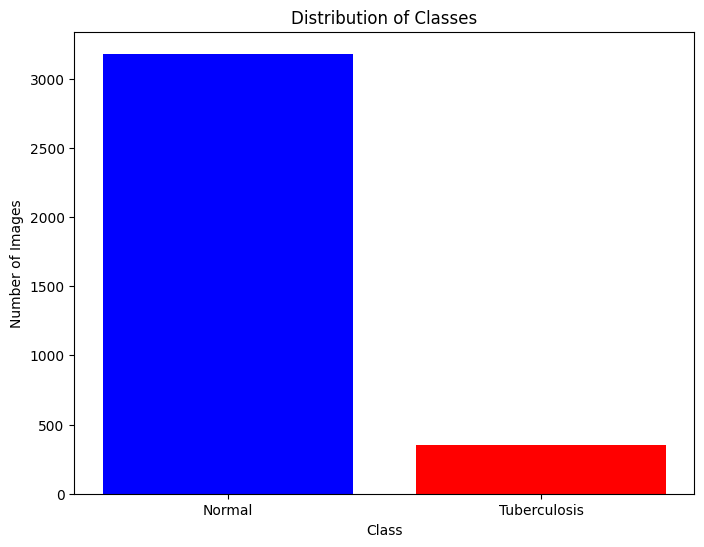

In [72]:
# Visualize the distribution of classes
plt.figure(figsize=(8, 6))
plt.bar(["Normal", "Tuberculosis"], [len(normal_images), len(tuberculosis_images)], color=['blue', 'red'])
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

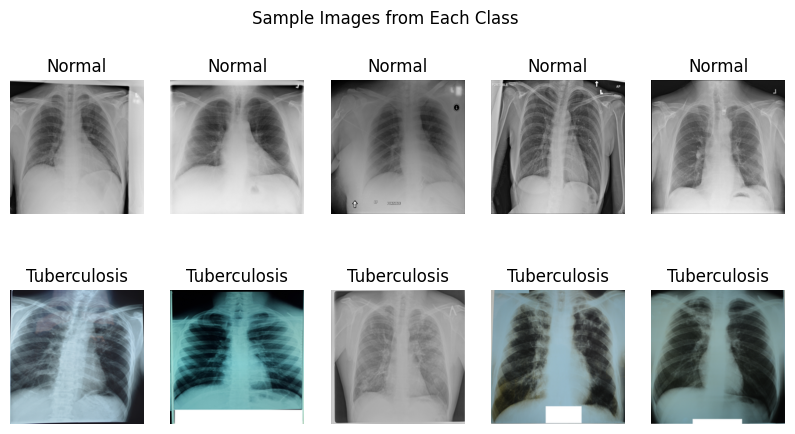

In [73]:
# Display sample images from each class
plt.figure(figsize=(10, 5))
for i in range(5):
    # Display Normal images
    plt.subplot(2, 5, i+1)
    plt.imshow(normal_images[random.randint(0, len(normal_images) - 1)])
    plt.title("Normal")
    plt.axis("off")

    # Display Tuberculosis images
    plt.subplot(2, 5, i+6)
    plt.imshow(tuberculosis_images[random.randint(0, len(tuberculosis_images) - 1)])
    plt.title("Tuberculosis")
    plt.axis("off")

plt.suptitle("Sample Images from Each Class")
plt.show()

In [74]:
def create_lenet_model(input_shape, num_classes=1):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(6, (5, 5), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (5, 5), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(120, activation='relu')(x)
    x = layers.Dense(84, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)  # Output layer for binary classification

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

input_shape = (256, 256, 3)
lenet_model = create_lenet_model(input_shape)

# Print model summary
lenet_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 252, 252, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 126, 126, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 122, 122, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 61, 61, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 59536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │     7,144,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,157,561 (27.30 MB)

 Trainable params: 7,157,561 (27.30 MB)

 Non-trainable params: 0 (0.00 B)

### model compilation

In [75]:
# Compile the model
lenet_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

### model training

In [76]:
# Train the model
history = lenet_model.fit(train_images, train_labels,
                          epochs=12,
                          batch_size=32,
                          validation_data=(test_images, test_labels))

Epoch 1/12
89/89 ━━━━━━━━━━━━━━━━━━━━ 50s 465ms/step - accuracy: 0.9058 - loss: 0.4901 - val_accuracy: 0.9575 - val_loss: 0.1221
Epoch 2/12
89/89 ━━━━━━━━━━━━━━━━━━━━ 75s 386ms/step - accuracy: 0.9138 - loss: 0.2183 - val_accuracy: 0.9603 - val_loss: 0.1137
Epoch 3/12
89/89 ━━━━━━━━━━━━━━━━━━━━ 31s 351ms/step - accuracy: 0.9566 - loss: 0.1351 - val_accuracy: 0.9745 - val_loss: 0.0883
Epoch 4/12
89/89 ━━━━━━━━━━━━━━━━━━━━ 31s 342ms/step - accuracy: 0.9737 - loss: 0.0714 - val_accuracy: 0.9745 - val_loss: 0.0793
Epoch 5/12
89/89 ━━━━━━━━━━━━━━━━━━━━ 31s 344ms/step - accuracy: 0.9739 - loss: 0.0735 - val_accuracy: 0.9788 - val_loss: 0.0649
Epoch 6/12
89/89 ━━━━━━━━━━━━━━━━━━━━ 33s 371ms/step - accuracy: 0.9887 - loss: 0.0376 - val_accuracy: 0.9830 - val_loss: 0.0628
Epoch 7/12
89/89 ━━━━━━━━━━━━━━━━━━━━ 32s 359ms/step - accuracy: 0.9887 - loss: 0.0351 - val_accuracy: 0.9830 - val_loss: 0.0569
Epoch 8/12
89/89 ━━━━━━━━━━━━━━━━━━━━ 31s 352ms/step - accuracy: 0.9916 - loss: 0.0287 - val_accu

### saving the model

In [77]:
# Save the model
lenet_model.save('safae_tuberculosis_detection_lenet_model.h5')

In [78]:
# Save the model
lenet_model.save('safae_tuberculosis_detection_lenet_model.keras')

### model evaluating

In [79]:
# Evaluate the model
test_loss, test_acc = lenet_model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}", f"Test loss: {test_loss}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9902 - loss: 0.0527
Test accuracy: 0.9915013909339905 Test loss: 0.042436353862285614


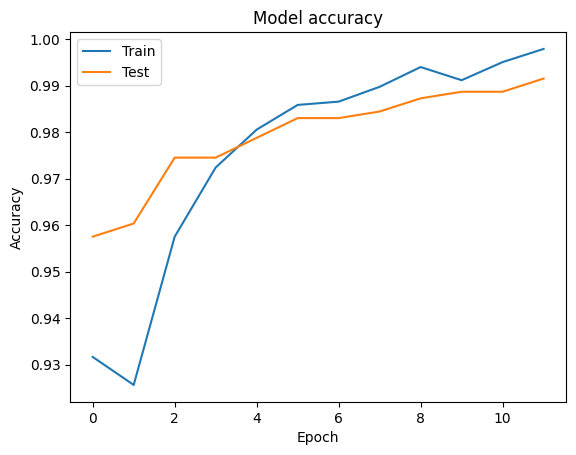

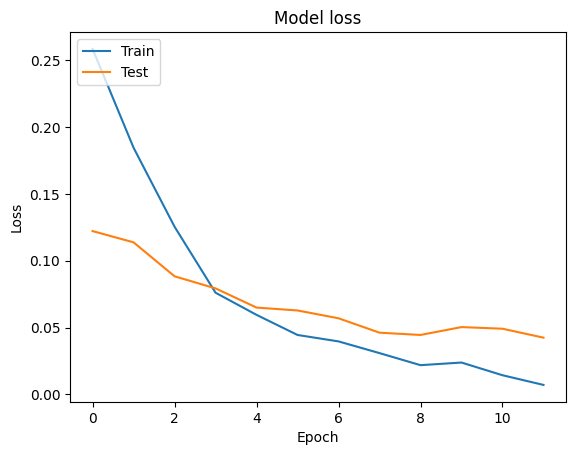

In [80]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Testing the model after training : prediction 

In [81]:
# Predict classes for the test set
y_pred_probs = lenet_model.predict(test_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (test_labels > 0.5).astype(int)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step


### Calculate classification metrics

In [82]:
# Calculate classification metrics
classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       636
           1       0.98      0.93      0.96        70

    accuracy                           0.99       706
   macro avg       0.99      0.96      0.98       706
weighted avg       0.99      0.99      0.99       706

Confusion Matrix:
[[635   1]
 [  5  65]]


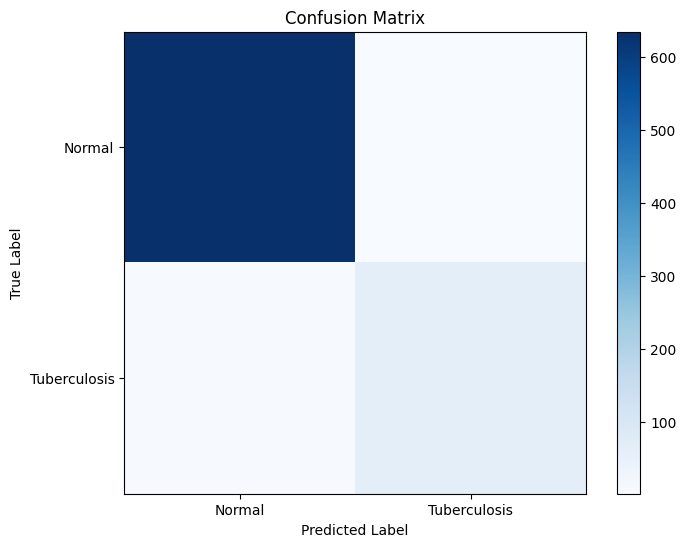

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step
Shape of predictions array: (706, 1)


In [83]:
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(np.arange(2), ["Normal", "Tuberculosis"])
plt.yticks(np.arange(2), ["Normal", "Tuberculosis"])
plt.show()

# Predictions
predictions = lenet_model.predict(test_images)
print("Shape of predictions array:", predictions.shape)

In [84]:
import tensorflow.keras as K
last_conv_layer = next(x for x in lenet_model.layers[::-1] if isinstance(x, K.layers.Conv2D))
last_conv_layer.name

'conv2d_3'

In [86]:
spatial_maps =  lenet_model.get_layer('conv2d_3').output
print(spatial_maps)

<KerasTensor shape=(None, 122, 122, 16), dtype=float32, sparse=False, name=keras_tensor_189>


In [87]:
# get the output of the model
output_with_batch_dim = lenet_model.output
print(f"Model output includes batch dimension, has shape {output_with_batch_dim.shape}")
print(f"excluding the batch dimension, the output for all 14 categories of disease has shape {output_with_batch_dim[0].shape}")

Model output includes batch dimension, has shape (None, 1)
excluding the batch dimension, the output for all 14 categories of disease has shape (1,)


### GradCAM (Gradient-weighted Class Activation Mapping) 

**is a technique for visualizing where a Convolutional Neural Network (CNN) model looks when making a decision. It helps to interpret and debug CNN models by highlighting the regions in the input image that are important for the predictions.**

In [98]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def GradCAM(model, image, interpolant=0.5, plot_results=True):
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    # Preprocess image and make prediction using our model
    original_img = np.asarray(image, dtype=np.float32)
    img = np.expand_dims(original_img, axis=0)

    # Predict
    prediction = model.predict(img)
    prediction_idx = np.argmax(prediction)

    # Find the last convolutional layer
    last_conv_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer
            break

    if last_conv_layer is None:
        raise ValueError("No convolutional layer found in the model.")

    # Create a model to extract feature maps and predictions
    gradient_model = Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])

    # Compute gradient of top predicted class
    with tf.GradientTape() as tape:
        conv2d_out, prediction = gradient_model(img)
        loss = prediction[:, prediction_idx]

    gradients = tape.gradient(loss, conv2d_out)

    output = conv2d_out[0]
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    activation_map = cv2.resize(activation_map.numpy(), (original_img.shape[1], original_img.shape[0]))
    activation_map = np.maximum(activation_map, 0)
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    activation_map = np.uint8(255 * activation_map)

    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    if plot_results:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
        plt.axis('off')
        plt.show()
    else:
        return cvt_heatmap

### the predict function : Last updates

In [91]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('safae_tuberculosis_detection_lenet_model.keras', compile=False)

# Define the preprocess_images function
def preprocess_images(image_dir):
    images = []
    filenames = []
    valid_extensions = (".png", ".jpg", ".jpeg")  # Add other extensions if needed
    for filename in os.listdir(image_dir):
        if filename.lower().endswith(valid_extensions):
            image_path = os.path.join(image_dir, filename)
            try:
                image = Image.open(image_path)
                image = image.convert("RGB")  # Convert grayscale to RGB
                image = image.resize((256, 256))  # Resize images to 256x256 pixels
                image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
                image = image.astype(np.float32)  # Ensure the image is of type float32
                images.append(image)
                filenames.append(filename)
            except Exception as e:
                print(f"Error processing {filename}: {e}")
    print(f"Loaded {len(images)} images from {image_dir}")
    return images, filenames

# Prediction function (accepts a preprocessed image)
@tf.function
def predict(image):
    image = tf.convert_to_tensor(image, dtype=tf.float32)  # Convert to tensor with dtype float32
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model(image, training=False)
    return "Tuberculosis" if prediction > 0.5 else "Normal"

# Assuming `image_dir` is the directory containing your images
image_dir = r'C:\Users\InkoHamza\Desktop\PFE_HEALTHCARE\data\normal'

# Preprocess the images
images, filenames = preprocess_images(image_dir)

def predict_by_index(index):
    try:
        if index < len(images):
            prediction_result = predict(images[index])
            print(f"Prediction for {filenames[index]}: {prediction_result}")
        else:
            print(f"Index {index} is out of range. Please enter a value between 0 and {len(images)-1}.")
    except Exception as e:
        print(f"Error predicting for index {index}: {e}")

# Example usage
index = 0  # You can change this to any valid index
predict_by_index(index) 

Loaded 3180 images from C:\Users\InkoHamza\Desktop\PFE_HEALTHCARE\data\normal
Prediction for Normal-1000.png: b'Normal'


### Verfie the path of our data before the testing 

In [105]:
data_dir + '/tubercolosis'

'C:\\Users\\InkoHamza\\Desktop\\PFE_HEALTHCARE\\data/tubercolosis'

In [106]:
data_dir + '/normal'

'C:\\Users\\InkoHamza\\Desktop\\PFE_HEALTHCARE\\data/normal'

### Test the GradCam Function 

Loaded 3180 images from C:\Users\InkoHamza\Desktop\PFE_HEALTHCARE\data\normal
Test image shape: (256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


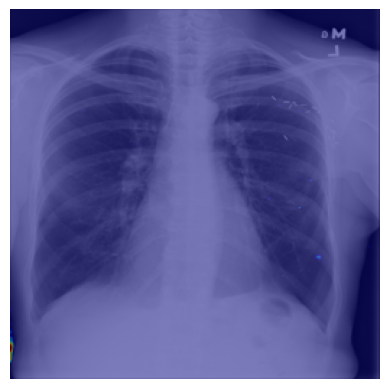

In [100]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the pre-trained model
model_path = 'safae_tuberculosis_detection_lenet_model.keras'
lenet_model = load_model(model_path, compile=False)

# Define the preprocess_images function
def preprocess_images(image_dir):
    images = []
    filenames = []
    valid_extensions = (".png", ".jpg", ".jpeg")  # Add other extensions if needed
    for filename in os.listdir(image_dir):
        if filename.lower().endswith(valid_extensions):
            image_path = os.path.join(image_dir, filename)
            try:
                image = Image.open(image_path)
                image = image.convert("RGB")  # Convert grayscale to RGB
                image = image.resize((256, 256))  # Resize images to 256x256 pixels
                image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
                image = image.astype(np.float32)  # Ensure the image is of type float32
                images.append(image)
                filenames.append(filename)
            except Exception as e:
                print(f"Error processing {filename}: {e}")
    print(f"Loaded {len(images)} images from {image_dir}")
    return images, filenames

# Assuming `image_dir` is the directory containing your images
image_dir = r'C:\Users\InkoHamza\Desktop\PFE_HEALTHCARE\data\normal'

# Preprocess the images
test_images, _ = preprocess_images(image_dir)  # Load normal images

# Select a test image
test_img = test_images[5]
print("Test image shape:", test_img.shape)

# Preprocessed image into GradCAM
GradCAM(lenet_model, test_img, plot_results=True)

Loaded 350 images from C:\Users\InkoHamza\Desktop\PFE_HEALTHCARE\data\tuberculosis
Test image shape: (256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


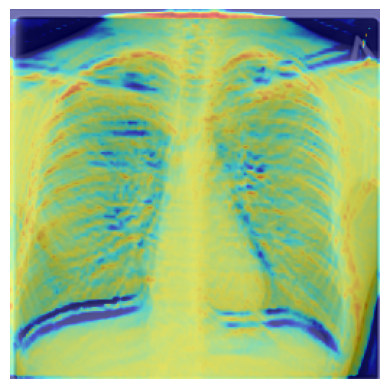

In [104]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the pre-trained model
model_path = 'safae_tuberculosis_detection_lenet_model.keras'
lenet_model = load_model(model_path, compile=False)

# Define the preprocess_images function
def preprocess_images(image_dir):
    images = []
    filenames = []
    valid_extensions = (".png", ".jpg", ".jpeg")  # Add other extensions if needed
    for filename in os.listdir(image_dir):
        if filename.lower().endswith(valid_extensions):
            image_path = os.path.join(image_dir, filename)
            try:
                image = Image.open(image_path)
                image = image.convert("RGB")  # Convert grayscale to RGB
                image = image.resize((256, 256))  # Resize images to 256x256 pixels
                image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
                image = image.astype(np.float32)  # Ensure the image is of type float32
                images.append(image)
                filenames.append(filename)
            except Exception as e:
                print(f"Error processing {filename}: {e}")
    print(f"Loaded {len(images)} images from {image_dir}")
    return images, filenames

# Assuming `image_dir` is the directory containing your images
image_dir = r'C:\Users\InkoHamza\Desktop\PFE_HEALTHCARE\data\tuberculosis'

# Preprocess the images
test_images, _ = preprocess_images(image_dir)  # Load normal images

# Select a test image
test_img = test_images[0]
print("Test image shape:", test_img.shape)

# Preprocessed image into GradCAM
GradCAM(lenet_model, test_img, plot_results=True)

### Tkinter Application 

In [108]:
import tkinter as tk
from tkinter import filedialog
from tkinter import Label
from tkinter import ttk
from PIL import Image, ImageTk
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('safae_tuberculosis_detection_lenet_model.keras')  # Replace with your model path

# Preprocessing function
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.convert("RGB")  # Convert grayscale to RGB
    image = image.resize((256, 256))  # Resize image to 256x256 pixels
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Prediction function
def predict(image_path):
    image = preprocess_image(image_path)
    prediction = model.predict(image)
    return "Tuberculosis" if prediction > 0.5 else "Normal"

# Function to upload and process image
def upload_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        # Display the image
        img = Image.open(file_path)
        img = img.resize((256, 256))
        img = ImageTk.PhotoImage(img)
        panel.configure(image=img)
        panel.image = img

        # Predict the image
        result = predict(file_path)
        result_label.config(text=f"Prediction: {result}")

# Initialize the Tkinter window
root = tk.Tk()
root.title("Tuberculosis Detection")
root.geometry("400x450")  # Set window size (width x height)

# Add a style for the widgets
style = ttk.Style()
style.configure('TButton', font=('Helvetica', 12), padding=10)
style.configure('TLabel', font=('Helvetica', 12))

# Add a frame for better layout
frame = ttk.Frame(root, padding="10")
frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))

# Add a button to upload image
upload_button = ttk.Button(frame, text="Upload Image", command=upload_image)
upload_button.grid(row=0, column=0, padx=10, pady=10, columnspan=2)

# Label to display the prediction result
result_label = ttk.Label(frame, text="Prediction: ", anchor="center")
result_label.grid(row=1, column=0, columnspan=2, padx=10, pady=10)

# Label to display the uploaded image
panel = Label(frame)
panel.grid(row=2, column=0, columnspan=2, pady=10)

# Add some padding around the widgets
for widget in frame.winfo_children():
    widget.grid_configure(padx=5, pady=5)

# Center the window
root.eval('tk::PlaceWindow . center')

# Start the Tkinter event loop
root.mainloop()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
